# **1.Importing Necessary Libraries:**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F


# **2. Model Architecture (VAE with Diffusion Process):**

In [ ]:
class DiffusionVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(DiffusionVAE, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, latent_dim)  # Mean of latent space
        self.fc22 = nn.Linear(512, latent_dim)  # Log variance of latent space
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # Sigmoid to ensure values in [0,1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# **3.Diffusion Process**

In [ ]:
# Function to add noise during training
def add_noise(x, noise_factor=0.2):
    noisy_x = x + noise_factor * torch.randn_like(x)
    return torch.clamp(noisy_x, 0., 1.)  # Clip to ensure values are between [0, 1]


# **4. Loss Function:**

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    # Binary cross entropy loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL divergence loss
    # Regularization term
    # KL(q(z|x) || p(z)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where q(z|x) is the posterior and p(z) is the prior (standard normal)
    # The divergence term encourages the posterior to be close to a standard normal distribution.
    # KL Divergence loss
    # This regularizes the latent space to be close to a standard normal distribution
    MSE = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + MSE


# **5. Dataset and DataLoader Setup:**

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset (you can replace this with your own dataset)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# **6. Model Initialization and Optimizer Setup:**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionVAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


# **7. Training Loop:**

In [ ]:
epochs = 10

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        noisy_data = add_noise(data)  # Add noise for diffusion
        optimizer.zero_grad()

        # Forward pass
        x_recon, mu, logvar = model(noisy_data.view(-1, 784))

        # Compute loss
        loss = loss_function(x_recon, data, mu, logvar)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}")


Epoch [1/10], Loss: 161.2554
Epoch [2/10], Loss: 128.3353
Epoch [3/10], Loss: 118.9164
Epoch [4/10], Loss: 115.1921
Epoch [5/10], Loss: 113.3216
Epoch [6/10], Loss: 112.0877
Epoch [7/10], Loss: 111.2319
Epoch [8/10], Loss: 110.5067
Epoch [9/10], Loss: 110.0474
Epoch [10/10], Loss: 109.6344


# **8. Testing the Model:**

In [ ]:
# Testing Loop
model.eval()
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        noisy_data = add_noise(data)  # Add noise for diffusion

        # Forward pass
        x_recon, mu, logvar = model(noisy_data.view(-1, 784))

        # Compute loss
        loss = loss_function(x_recon, data, mu, logvar)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader.dataset):.4f}")


Test Loss: 109.0150


# **9.Visualizing the Reconstructed Images:**

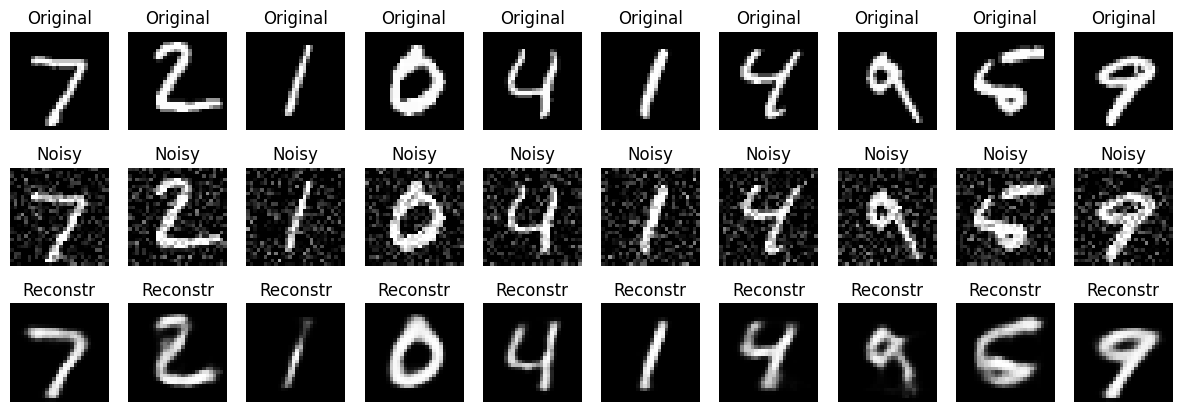

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, test_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        noisy_data = add_noise(data)  # Add noise to the images

        # Forward pass
        recon_batch, _, _ = model(noisy_data.view(-1, 784))

        # Plot original, noisy, and reconstructed images
        fig, axes = plt.subplots(3, num_images, figsize=(15, 5))
        for i in range(num_images):
            # Original image
            axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Original")

            # Noisy image
            axes[1, i].imshow(noisy_data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title("Noisy")

            # Reconstructed image
            axes[2, i].imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[2, i].axis('off')
            axes[2, i].set_title("Reconstr")
        plt.show()

# Call this function after training to visualize the reconstructions
visualize_reconstructions(model, test_loader)


# **10.Visualizing the Training Loss:**

Epoch [1/10], Loss: 109.2720
Epoch [2/10], Loss: 108.9747
Epoch [3/10], Loss: 108.7423
Epoch [4/10], Loss: 108.4469
Epoch [5/10], Loss: 108.3020
Epoch [6/10], Loss: 108.0941
Epoch [7/10], Loss: 107.8789
Epoch [8/10], Loss: 107.6346
Epoch [9/10], Loss: 107.5355
Epoch [10/10], Loss: 107.4242


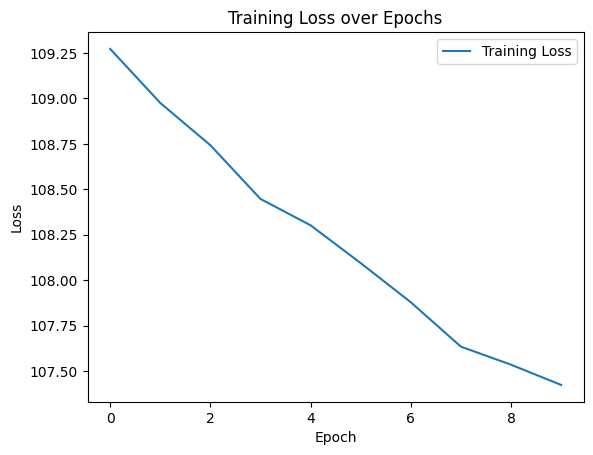

In [ ]:
# Modify the training loop to store loss values for visualization
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        noisy_data = add_noise(data)  # Add noise for diffusion
        optimizer.zero_grad()

        # Forward pass
        x_recon, mu, logvar = model(noisy_data.view(-1, 784))

        # Compute loss
        loss = loss_function(x_recon, data, mu, logvar)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}")

# Plot training loss over epochs
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


# **11.Visualizing the Latent Space:**

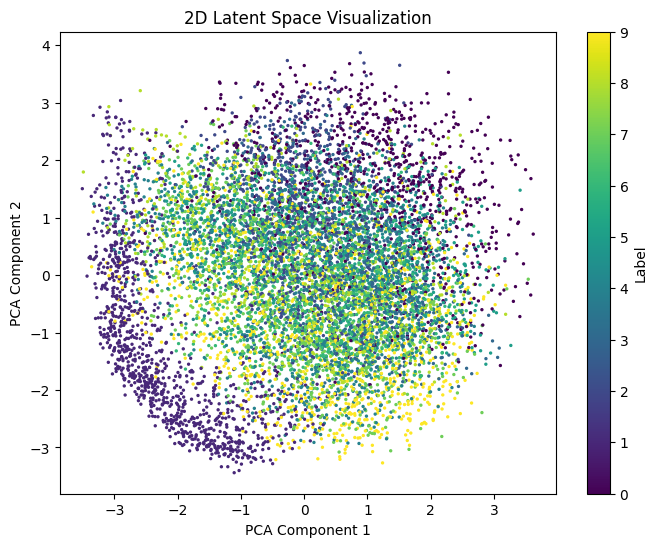

In [ ]:
import numpy as np  # Import NumPy for handling arrays

# Modify the latent space visualization function
def visualize_latent_space(model, test_loader):
    model.eval()
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            mu, logvar = model.encode(data.view(-1, 784))  # Get the mean (mu) of the latent space
            all_latents.append(mu.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Flatten lists
    all_latents = np.concatenate(all_latents, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Apply PCA to reduce dimensions to 2D
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    reduced_latents = pca.fit_transform(all_latents)

    # Plot the 2D latent space
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=all_labels, cmap='viridis', s=2)
    plt.colorbar(label='Label')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('2D Latent Space Visualization')
    plt.show()

# Call this function to visualize the latent space
visualize_latent_space(model, test_loader)
